Accuracy : 0.8105
Confusion matrix : [[1560   33]
 [ 346   61]]


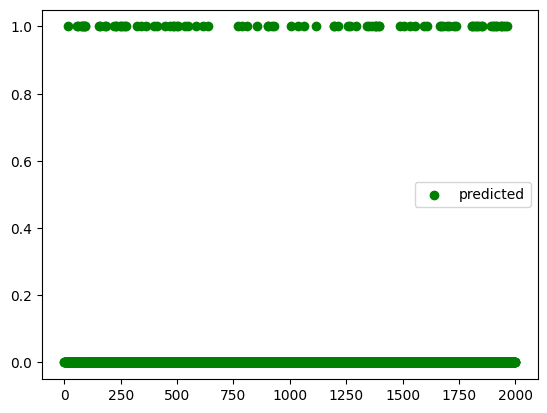

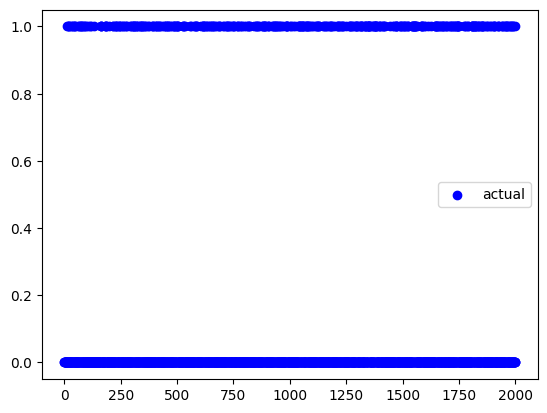

In [45]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# reading the dataset
df = pd.read_csv("D:/Customer_Churn_Prediction/Churn_Modelling.csv")

# removing rows where Exited is missing
df = df.dropna(subset=["Exited"])

# scaling the features
scaler = StandardScaler()

# setting input features and output label
x = df.drop(columns=["Surname", "Exited", "Geography", "Gender"])
y = df["Exited"]

# fitting scaler and transforming features
x = scaler.fit_transform(x)

# splitting into train and test data
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# building the logistic regression model
model = LogisticRegression()
model.fit(x_train, y_train)

# predicting on the test data
y_pred = model.predict(x_test)

# printing the accuracy
print("Accuracy :", accuracy_score(y_test, y_pred))

# printing the confusion matrix
print("Confusion matrix :", confusion_matrix(y_test, y_pred))

# plotting predicted values
plt.scatter(range(len(y_pred)), y_pred, color="g", label="predicted")
plt.legend()
plt.show()

# plotting actual values
plt.scatter(range(len(y_test)), y_test, color="b", label="actual")
plt.legend()
plt.show()


Accuracy: 0.841


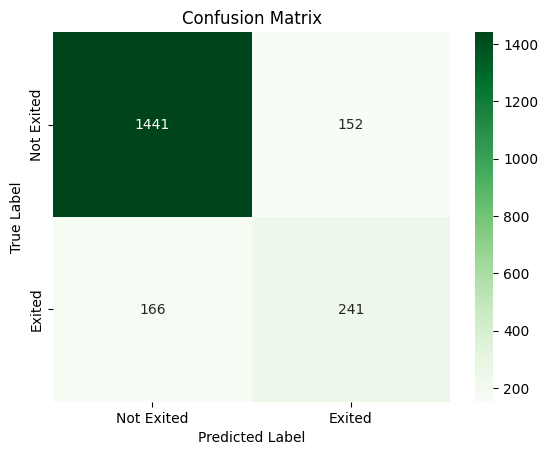

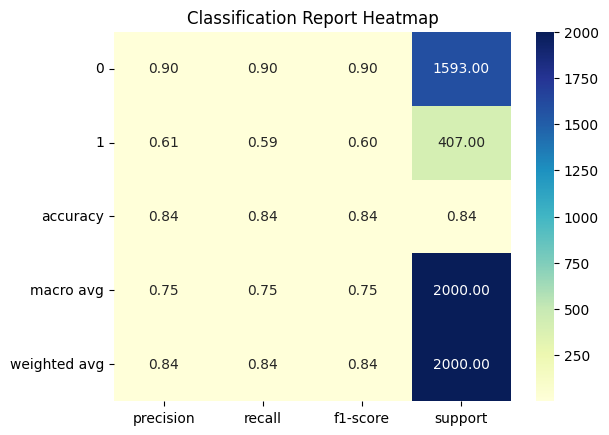

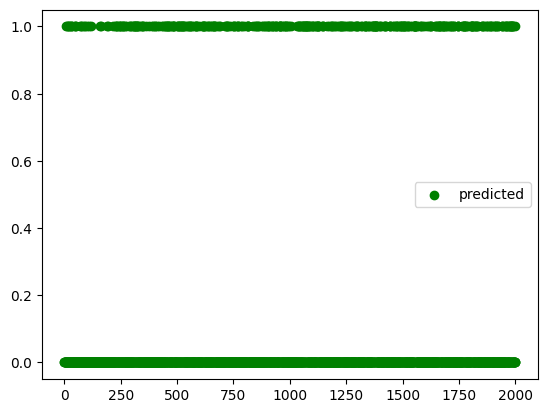

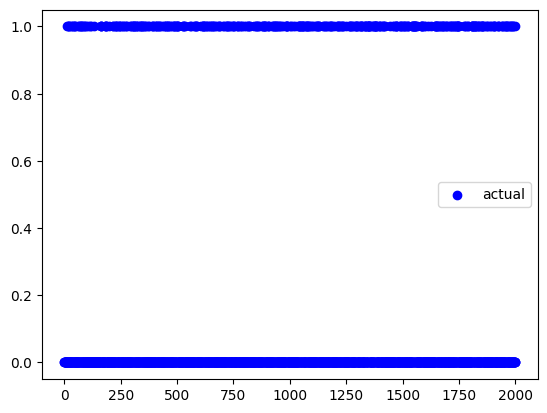

In [43]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from matplotlib import pyplot as plt

# reading the dataset
df = pd.read_csv("D:/Customer_Churn_Prediction/Churn_Modelling.csv")  

# removing rows where Exited is missing
df = df.dropna(subset=["Exited"]) 

# converting Gender and Geography to dummy variables
df = pd.get_dummies(df, columns=["Gender", "Geography"], drop_first=True)

# setting input features and output label
X = df.drop(columns=["Surname", "RowNumber", "Exited"])  
y = df["Exited"]

# splitting into train and test data
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# storing CustomerId separately to use later
test_ids = X_test_full["CustomerId"].values

# dropping CustomerId from features
X_train = X_train_full.drop(columns=["CustomerId"])
X_test  = X_test_full.drop(columns=["CustomerId"])

# scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# applying SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# building the random forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_res, y_train_res)

# predicting on the test data
y_pred = rf_model.predict(X_test_scaled)

# getting prediction probabilities
y_proba = rf_model.predict_proba(X_test_scaled)[:, 1]  

# printing accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# getting detailed classification report
report = classification_report(y_test, y_pred, output_dict=True)

# setting a threshold of 0.5 for classification
threshold = 0.5 

# creating a dataframe for results
results = pd.DataFrame({
    "CustomerId": test_ids,
    "ExitedProb": np.round(y_proba, 3),
    "PredictedExited": (y_proba >= threshold).astype(int)
})

# checking if anyone predicted to exit, and setting action
if (results["PredictedExited"] == 1).any():
    results["Action"] = "Send retention offer"

# sorting results so that exited customers come on top
results.sort_values(by="PredictedExited", ascending=False, inplace=True)

# saving the results to csv
results.to_csv("churn_predictions.csv", index=False)

# plotting confusion matrix
sns.heatmap(data=confusion_matrix(y_test, y_pred), 
            annot=True, 
            fmt='d',  
            cmap="Greens", 
            xticklabels=["Not Exited", "Exited"], 
            yticklabels=["Not Exited", "Exited"])

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# plotting classification report heatmap
report_df = pd.DataFrame(report).transpose()
sns.heatmap(data=report_df, 
            annot=True, 
            fmt='.2f', 
            cmap="YlGnBu",
            xticklabels=report_df.columns,
            yticklabels=report_df.index)

plt.title("Classification Report Heatmap")
plt.show()
plt.scatter(range(len(y_pred)), y_pred , color= "g" , label ="predicted")
plt.legend()
plt.show()
plt.scatter(range(len(y_test)),y_test , color ="b",label="actual")

plt.legend()
plt.show()


